# You are what you eat - Relating Demographic Data to Food Consumption Habits

In [1]:
#%matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns  # needed for heatmap
from os.path import join
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf
import pickle
plt.rcParams['figure.figsize'] = [7, 5]

In [2]:
# define paths for data
FOLDER_PATH = 'data'
PURCHASES_PATH = 'area_level_purchases'
OSWARD_GROCERY = 'year_osward_grocery.csv'
WARD_ATLAS = 'ward-atlas-data.csv'

ward_data_path = join(FOLDER_PATH, PURCHASES_PATH, OSWARD_GROCERY)
atlas_data_path = join(FOLDER_PATH, WARD_ATLAS)

# load the data sets
df_ward = pd.read_csv(ward_data_path, sep=',', index_col=0)
df_atlas = pd.read_csv(atlas_data_path, sep=',', encoding='iso-8859-1')

The `df_atlas` data set looks very messy. Row 0 contains info about the data. For every ward and demographic marker yearly (from 2001 to 2006) values exist in columns. According to the [source](https://data.london.gov.uk/dataset/ward-profiles-and-atlas) this data set was collected in September 2015 with the most up-to-date information available. Thus, for many markers, the last available information dates to 2015 or even earlier (e.g. 2013). Our first step is to clean the data set from outdated columns and only keep the most up-to-date demographic markers.

As indicated by the title, we are interested in demographic markers which help classifying different classes of people. These are for example gender, religion, ethnicity, wealth, age. Thus, in the following, we drop columns which we deem not helpful in classifying people into groups. We acknowledge that this process can be rather biased, however, as the data set has 946 columns, we see the need to reduce the data set's complexity.

In [3]:
def drop_redundant_data(df_atlas):
    # clean age (columns after 2013 are projections, therefore keep 2013 columns)
    cond = df_atlas.columns.str.startswith('Population and Age') & ~df_atlas.columns.str.contains('2013')
    df_atlas = df_atlas.loc[:, ~cond]
    # drop absolute population values
    df_atlas = df_atlas.drop(['Population and Age; Population Estimates and Projections; 2013',
                   'Population and Age; Aged 0-15; 2013',
                   'Population and Age; Aged 16-64; 2013',
                   'Population and Age; Aged 65+; 2013',
                   'Population and Age; All ages; 2013',
                   'Population and Age; Mean age; 2013',
                   'Population and Age; Median age; 2013'], axis=1)
    # delete population density
    cond = df_atlas.columns.str.startswith('Area and Density')
    df_atlas = df_atlas.loc[:, ~cond]
    # delete the 18 ethnic groups for now, as they add complexity
    cond = df_atlas.columns.str.startswith('Diversity; Ethnic Group 18 groups')
    df_atlas = df_atlas.loc[:, ~cond]
    # delete household language (of no interest) 
    cond = df_atlas.columns.str.startswith('Diversity; Household Language - 2011 Census')
    df_atlas = df_atlas.loc[:, ~cond]
    # delete household composition data
    cond = df_atlas.columns.str.startswith('Household composition')
    df_atlas = df_atlas.loc[:, ~cond]
    # delete household repossesion
    cond = df_atlas.columns.str.startswith('Home repossessions')
    df_atlas = df_atlas.loc[:, ~cond]
    # delete outdated birth and death markers
    cond = df_atlas.columns.str.startswith('Births and deaths')
    df_atlas = df_atlas.loc[:, ~cond]
    # delete outdated life expectancy
    cond = df_atlas.columns.str.startswith('Life Expectancy')
    df_atlas = df_atlas.loc[:, ~cond]
    # delete outdated housing markers
    cond = df_atlas.columns.str.startswith('Housing type and Tenure')
    df_atlas = df_atlas.loc[:, ~cond]
    cond = df_atlas.columns.str.startswith('House Prices')
    df_atlas = df_atlas.loc[:, ~cond]
    # delete tax related data (not of interest)
    cond = df_atlas.columns.str.startswith('Dwellings and Council tax')
    df_atlas = df_atlas.loc[:, ~cond]
    # delete dwelling data which is not of interest
    cond = df_atlas.columns.str.startswith('Property Type') | df_atlas.columns.str.startswith('Size of dwellings') | df_atlas.columns.str.startswith('Property build period')
    df_atlas = df_atlas.loc[:, ~cond]
    # delete outdated income data
    cond = df_atlas.columns.str.startswith('Household Income') & ~df_atlas.columns.str.contains('2012/13')
    df_atlas = df_atlas.loc[:, ~cond]
    # outdated employment data
    cond = df_atlas.columns.str.startswith('Employment')
    df_atlas = df_atlas.loc[:, ~cond]
    # delete benefits claimants and jobseekers allowance
    cond = df_atlas.columns.str.startswith('Benefits claimants') | df_atlas.columns.str.startswith('Jobseekers Allowance')
    df_atlas = df_atlas.loc[:, ~cond]
    # delete out of work families
    cond = df_atlas.columns.str.startswith('Out-of-Work Families')
    df_atlas = df_atlas.loc[:, ~cond]
    # outdated poverty
    cond = df_atlas.columns.str.startswith('Children in Poverty')
    df_atlas = df_atlas.loc[:, ~cond]
    # outdated "intelligence" scores
    cond = df_atlas.columns.str.startswith('GCSE')
    df_atlas = df_atlas.loc[:, ~cond]
    cond = df_atlas.columns.str.startswith('A-Level Point Scores')
    df_atlas = df_atlas.loc[:, ~cond]
    # pupil abscence not if interest
    cond = df_atlas.columns.str.startswith('Pupil Absence')
    df_atlas = df_atlas.loc[:, ~cond]
    # individual crimes not of interest, only crime rate
    cond = df_atlas.columns.str.startswith('Crime') # & ~df_atlas.columns.str.contains('Total crime rate; 2014/15')
    df_atlas = df_atlas.loc[:, ~cond]
    # further columns not of interest
    cond = df_atlas.columns.str.startswith('Fires') | df_atlas.columns.str.startswith('Ambulance') \
    | df_atlas.columns.str.startswith('Binge Drinking') | df_atlas.columns.str.startswith('Road Casualties') \
    | df_atlas.columns.str.startswith('Air Emissions') | df_atlas.columns.str.startswith('Land Use') \
    | df_atlas.columns.str.startswith('Access to green space and nature') | df_atlas.columns.str.startswith('Public Transport Accessibility')\
    | df_atlas.columns.str.startswith('Car access') | df_atlas.columns.str.startswith('Travel to work by bicycle') \
    | df_atlas.columns.str.startswith('Workplace employment') | df_atlas.columns.str.startswith('Nat Insurance No. registrations') \
    | df_atlas.columns.str.startswith('Election turnout')
    df_atlas = df_atlas.loc[:, ~cond]
    # obesity already available in cleaned format
    cond = df_atlas.columns.str.startswith('Childhood Obesity Prevalence')
    df_atlas = df_atlas.loc[:, ~cond]
    # delete old indices of deprivation
    cond = df_atlas.columns.str.startswith('Indices of Deprivation') & ~df_atlas.columns.str.contains('2010')
    df_atlas = df_atlas.loc[:, ~cond]
    cond = df_atlas.columns.str.startswith('Indices of Deprivation') & ~df_atlas.columns.str.endswith('Average Score; 2010')
    df_atlas = df_atlas.loc[:, ~cond]
    
    df_atlas.drop('Unnamed: 0', axis=1, inplace=True)
    df_atlas.drop(df_atlas.index[-3:], inplace=True)
    df_atlas.drop(df_atlas.index[0], inplace=True)
    return df_atlas

df_atlas = drop_redundant_data(df_atlas)

In [4]:
# The first 4 columns seem to have a wrong name
df_atlas.rename(columns={'Unnamed: 1': 'New Code', 'Unnamed: 2': 'Borough', 
                         'Unnamed: 3': 'Names'}, inplace=True)

# very long column names, rename columns to more concise names
import re
rename_map = {name: re.sub('.*; ', '', name) for name in df_atlas.columns.values}
# after inspection 'Household Income; Median Modelled Household income (£); 2012/13',
# 'Household Income; Mean Modelled Household income (£); 2012/13',
# 'Happiness and Well-being; Subjective well-being average score, 2011/12 and 2012/13; ',
# and 'Indices of Deprivation; Average Score; 2010' have been replaced too much, manually add those column names
rename_map['Household Income; Median Modelled Household income (£); 2012/13'] = 'Household Income Mean'
rename_map['Household Income; Mean Modelled Household income (£); 2012/13'] = 'Household Income Median'
rename_map['Happiness and Well-being; Subjective well-being average score, 2011/12 and 2012/13; '] = 'Well-Being'
rename_map['Indices of Deprivation; Average Score; 2010'] = 'IOD AVG'
df_atlas.rename(columns=rename_map, inplace=True)
                         
df_atlas.rename(columns={'% No qualifications': 'No qualifications', 
                         '% Highest level of qualification: Level 1 qualifications': 'Level 1 qualifications', 
                         '% Highest level of qualification: Level 2 qualifications': 'Level 2 qualifications', 
                         '% Highest level of qualification: Apprenticeship': 'Apprenticeship qualifications', 
                         '% Highest level of qualification: Level 3 qualifications': 'Level 3 qualifications', 
                         '% Highest level of qualification: Level 4 qualifications and above': 'Level >=4 qualifications',
                         '% Highest level of qualification: Other qualifications': 'Other qualifications', 
                         '% People with Bad or Very Bad Health': 'Bad Health',
                         '% People whose Day-to-day activities are limited a lot': 'Limited activities'},
                inplace=True)

In [5]:
# to numeric conversion
df_atlas.loc[:, 'Aged 0-15':] = df_atlas.loc[:, 'Aged 0-15':].apply(pd.to_numeric, errors='coerce')

In [6]:
age_cols = ['Aged 0-15', 'Aged 16-64', 'Aged 65+'] #sum to 1
ethnicities_cols = ['White', 'Mixed', 'Asian or Asian British', 'Black or Black British', 'Other'] #sum to 1
religion_cols = ['Christian', 'Buddhist', 'Hindu', 'Jewish', 'Muslim', 'Sikh',
       'No religion', 'Other religions', 'Religion not stated'] # sum to 1
born_cols = ['Born in UK', 'Not Born in UK'] # sum to 1
wealth_cols = ['Household Income Median', 'IOD AVG', 'Well-Being']
qualilication_cols = ['No qualifications', 'Level 1 qualifications', 'Level 2 qualifications',
       'Apprenticeship qualifications', 'Level 3 qualifications',
       'Level >=4 qualifications', 'Other qualifications'] # sum to 1 
disability_cols = ['Bad Health', 'Limited activities']
all_features = age_cols + ethnicities_cols + religion_cols + born_cols + wealth_cols + qualilication_cols + disability_cols

normalizing data

In [7]:
def normalize(df, cols):
    total = df[cols].sum(axis=1)
    df[cols] = df[cols].div(total, axis=0)
    return df

def standartize(df, cols):
    means = df[cols].mean()
    stds = df[cols].std()
    df[cols] = (df[cols] - means) / stds
    return df

def min_max_scaling(df, cols):
    mins = df[cols].min()
    maxs = df[cols].max()
    df[cols] = (df[cols] - mins) / (maxs - mins)
    return df

In [8]:
#normalize
df_atlas[age_cols] /= 100
df_atlas = normalize(df_atlas, ethnicities_cols)
df_atlas = normalize(df_atlas, religion_cols)
df_atlas = normalize(df_atlas, born_cols)
df_atlas[qualilication_cols] /= 100

In [9]:
for cols in [age_cols, ethnicities_cols, religion_cols, born_cols, qualilication_cols]:
    print(any(np.abs(df_atlas[cols].sum(axis=1) - 1) > 0.01))

False
False
False
False
False


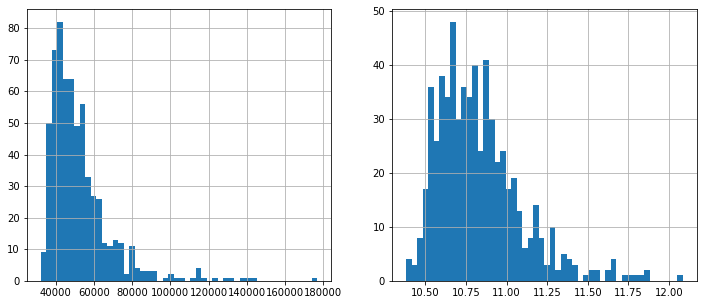

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
df_atlas['Household Income Median'].hist(bins=50, ax=ax[0])
(np.log(df_atlas['Household Income Median'])).hist(bins=50, ax=ax[1])
plt.show()
#haivy-tailed, makes sense to apply log transform before min-max rescaling

In [11]:
df_atlas['Household Income Median'] = df_atlas['Household Income Median'].apply(np.log)

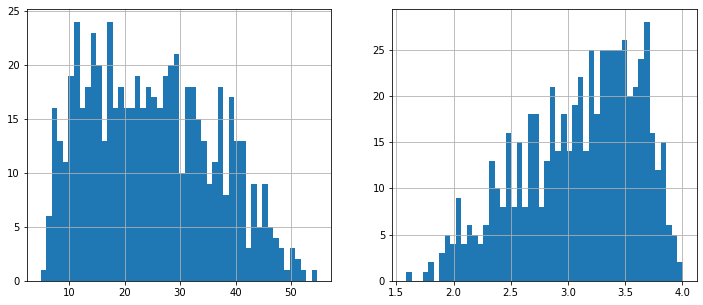

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
df_atlas['IOD AVG'].hist(bins=50, ax=ax[0])
(np.log(df_atlas['IOD AVG'])).hist(bins=50, ax=ax[1])
plt.show()
#no sense to apply log transform

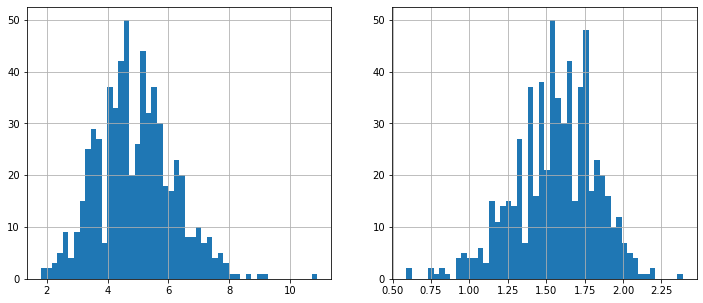

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
df_atlas['Bad Health'].hist(bins=50, ax=ax[0])
(np.log(df_atlas['Bad Health'])).hist(bins=50, ax=ax[1])
plt.show()
#no sense to apply log transform

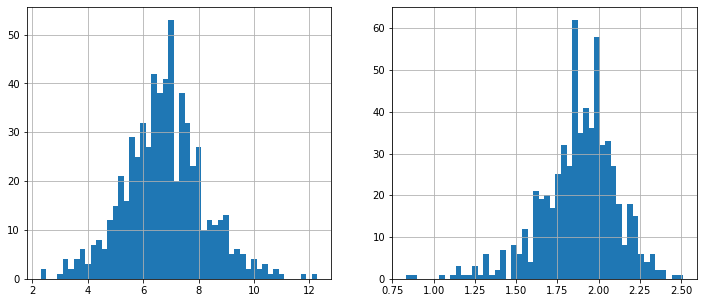

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
df_atlas['Limited activities'].hist(bins=50, ax=ax[0])
(np.log(df_atlas['Limited activities'])).hist(bins=50, ax=ax[1])
plt.show()
#no sense to apply log transform

In [15]:
#standartizing all features to have 0 mean and 1 variance
for col in all_features:
    df_atlas = standartize(df_atlas, col)

In [16]:
df_atlas[all_features].mean(axis=0)

Aged 0-15                        8.369483e-15
Aged 16-64                      -3.434053e-15
Aged 65+                        -2.079936e-15
White                            1.676259e-15
Mixed                           -2.708034e-15
Asian or Asian British          -1.104894e-16
Black or Black British           2.391509e-15
Other                           -3.463896e-16
Christian                        2.402878e-15
Buddhist                         2.509282e-15
Hindu                           -5.075051e-16
Jewish                          -1.461942e-16
Muslim                           6.918022e-16
Sikh                             5.169198e-17
No religion                      1.002753e-15
Other religions                  2.978950e-16
Religion not stated             -6.980194e-16
Born in UK                      -1.985612e-15
Not Born in UK                  -1.204725e-15
Household Income Median          3.838139e-14
IOD AVG                          1.971756e-17
Well-Being                      -4

In [17]:
df_atlas[all_features].std(axis=0)

Aged 0-15                        1.0
Aged 16-64                       1.0
Aged 65+                         1.0
White                            1.0
Mixed                            1.0
Asian or Asian British           1.0
Black or Black British           1.0
Other                            1.0
Christian                        1.0
Buddhist                         1.0
Hindu                            1.0
Jewish                           1.0
Muslim                           1.0
Sikh                             1.0
No religion                      1.0
Other religions                  1.0
Religion not stated              1.0
Born in UK                       1.0
Not Born in UK                   1.0
Household Income Median          1.0
IOD AVG                          1.0
Well-Being                       1.0
No qualifications                1.0
Level 1 qualifications           1.0
Level 2 qualifications           1.0
Apprenticeship qualifications    1.0
Level 3 qualifications           1.0
L

In [18]:
df_ward.columns.values

array(['weight', 'weight_perc2.5', 'weight_perc25', 'weight_perc50',
       'weight_perc75', 'weight_perc97.5', 'weight_std', 'weight_ci95',
       'volume', 'volume_perc2.5', 'volume_perc25', 'volume_perc50',
       'volume_perc75', 'volume_perc97.5', 'volume_std', 'volume_ci95',
       'fat', 'fat_perc2.5', 'fat_perc25', 'fat_perc50', 'fat_perc75',
       'fat_perc97.5', 'fat_std', 'fat_ci95', 'saturate',
       'saturate_perc2.5', 'saturate_perc25', 'saturate_perc50',
       'saturate_perc75', 'saturate_perc97.5', 'saturate_std',
       'saturate_ci95', 'salt', 'salt_perc2.5', 'salt_perc25',
       'salt_perc50', 'salt_perc75', 'salt_perc97.5', 'salt_std',
       'salt_ci95', 'sugar', 'sugar_perc2.5', 'sugar_perc25',
       'sugar_perc50', 'sugar_perc75', 'sugar_perc97.5', 'sugar_std',
       'sugar_ci95', 'protein', 'protein_perc2.5', 'protein_perc25',
       'protein_perc50', 'protein_perc75', 'protein_perc97.5',
       'protein_std', 'protein_ci95', 'carb', 'carb_perc2.5',
      

In [19]:
important_cols = ['weight', 'volume', 'fat', 'saturate', 'salt', 'sugar', 'protein', 'carb',
                 'fibre', 'alcohol', 'energy_fat', 'energy_saturate', 'energy_sugar', 'energy_protein',
                 'energy_carb', 'energy_fibre', 'energy_alcohol', 'energy_tot', 'f_energy_fat', 'f_energy_saturate', 
                 'f_energy_sugar', 'f_energy_protein', 'f_energy_carb', 'f_energy_fibre', 'f_energy_alcohol', 
                 'energy_density', 'h_nutrients_weight', 'h_nutrients_weight_norm', 'h_nutrients_calories',
                  'h_nutrients_calories_norm', 'representativeness_norm']

In [20]:
# before merging set index of df_atlas to the ward code
df_atlas.set_index('New Code', drop=True, inplace=True)

In [21]:
# merge the data sets by ward
df_ward_atlas = pd.merge(df_ward[important_cols], df_atlas, how='inner', left_index=True, right_index=True, validate='1:1')
df_ward_atlas

,weight,volume,fat,saturate,salt,sugar,protein,carb,fibre,alcohol,...,Level 2 qualifications,Apprenticeship qualifications,Level 3 qualifications,Level >=4 qualifications,Other qualifications,% of 16+ who are schoolchildren and full-time students: Age 18 and over,Bad Health,Limited activities,Well-Being,IOD AVG
E05000026,449.535137,125.960833,9.488797,3.693721,0.583240,10.966213,4.977560,19.381951,1.564721,0.198172,...,-0.135178,-0.607835,-0.990268,-0.245565,1.873423,14.3,-0.492858,-1.121216,0.831413,0.694138
E05000027,413.130263,110.664114,9.733634,3.565913,0.568184,10.514427,5.211694,18.950348,1.581960,0.209917,...,1.172269,0.118347,-0.589674,-1.629791,-0.257354,5.8,1.409580,1.429760,-0.863156,0.992115
E05000028,407.100472,121.990710,9.216310,3.613582,0.610536,10.690272,5.192412,19.662048,1.572323,0.225425,...,1.047751,0.325827,-0.689822,-1.326505,0.043140,7.7,1.647385,1.429760,-0.076466,0.601395
E05000029,384.173858,122.245578,9.700137,3.961264,0.533180,12.938606,4.718184,20.084734,1.550344,0.200380,...,0.923232,0.533308,-0.239154,-1.412047,-0.421260,5.3,1.488848,2.119213,-1.651271,1.168602
E05000030,356.882607,109.959688,9.381808,3.614663,0.566784,11.332898,5.307003,19.581403,1.607947,0.168952,...,1.421307,1.155749,-0.239154,-1.489813,-1.022248,5.0,0.775434,1.291869,0.799847,0.065051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E05000645,387.651694,100.374890,9.011954,3.558849,0.584727,9.403091,5.499603,16.729870,1.609476,0.292334,...,-1.349235,-0.815315,-1.240639,1.356405,0.015822,6.4,0.616897,0.257690,0.063086,-0.504062
E05000646,391.296517,102.209867,8.810350,3.379945,0.604999,9.350598,5.584789,17.240961,1.640990,0.209072,...,-1.193587,-0.815315,-0.840045,1.200874,0.152411,7.7,0.537629,0.188745,-0.173037,-0.262902
E05000647,391.146713,115.080184,8.642757,3.398100,0.584833,9.446028,5.321004,17.579308,1.680360,0.299310,...,-1.504884,-0.711575,-0.990268,1.620807,-0.038813,7.7,0.220556,-0.500708,1.736755,-0.452034
E05000648,400.832576,109.727023,8.919674,3.512147,0.549463,9.623928,5.259262,17.940815,1.611090,0.195706,...,-0.726642,-0.919055,-0.789971,-0.152246,0.889987,7.4,2.994945,2.739721,1.152150,1.459673


In [22]:
def forward_feature_selection(df_corrs, target_col, verbose=False):

    num_features = 1
    repeat = 100
    best_score = 0
    best_num_features = 0
    delay = 10
    not_improvements = 0

    while (not_improvements < delay) and (num_features < len(df_corrs)):
        features = list(df_corrs[:num_features].keys())
        x_data = df_ward_atlas[features]
        y_data = df_ward_atlas[target_col]
        res_train = []
        res_test = []
        for i in range(repeat):
            x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 1/3)
            model = LinearRegression()
            model.fit(x_train, y_train)
            res_train.append(model.score(x_train, y_train))
            res_test.append(model.score(x_test, y_test))
        res_train = np.array(res_train)
        res_test = np.array(res_test)
        res_train = np.mean(res_train)
        res_test = np.mean(res_test)
        if (res_test > best_score):
            summary_str = 'R2 score on test data improved by {:.5}'.format(res_test-best_score)
            best_score = res_test
            best_num_features = num_features
            not_improvements = 0
        else:
            summary_str = 'R2 score on test data did not improved'
            not_improvements += 1
        if verbose:
            print('Added feature {}: {}'.format(num_features, df_corrs.keys()[num_features-1]))
            print('Average r2_score on train data: {:.5}, on test data {:.5}'.format(res_train, res_test))
            print(summary_str + '\n')
        num_features += 1
    
    return best_score, best_num_features

In [23]:
def forward_feature_selection_brute_force(df_corrs_, target_col, verbose=False):
    num_features = 1
    repeat = 100
    global_test_best = 0
    selected_cols_best = None
    delay = 3
    not_improvements = 0

    df_corrs = df_corrs_.copy()
    selected_cols = []

    while (not_improvements < delay) and (len(df_corrs) > 0):
        res_train = {}
        res_test = {}
        local_train_best = 0
        local_test_best = 0
        best_new_col = None
        for new_col in df_corrs.index:
            trial_cols = selected_cols + [new_col]       
            x_data = df_ward_atlas[trial_cols]
            y_data = df_ward_atlas[target_col]
            res_train[new_col] = []
            res_test[new_col] = []
            for i in range(repeat):
                x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.2)
                model = LinearRegression()
                model.fit(x_train, y_train)
                res_train[new_col].append(model.score(x_train, y_train))
                res_test[new_col].append(model.score(x_test, y_test))
            res_train[new_col] = np.array(res_train[new_col])
            res_test[new_col] = np.array(res_test[new_col])
            res_train[new_col] = np.mean(res_train[new_col])
            res_test[new_col] = np.mean(res_test[new_col])
            if (res_test[new_col] > local_test_best):
                local_test_best = res_test[new_col]
                local_train_best = res_train[new_col]
                best_new_col = new_col
        
        selected_cols.append(best_new_col)
        df_corrs.drop(best_new_col, axis=0, inplace=True)
        if (local_test_best > global_test_best):
            summary_str = 'R2 score on test data improved by {:.5}'.format(local_test_best-global_test_best)
            global_test_best = local_test_best
            selected_cols_best = selected_cols.copy()
            not_improvements = 0
        else:
            summary_str = 'R2 score on test data did not improved'
            not_improvements += 1
        if verbose:
            print('Added feature {}: {}'.format(num_features, best_new_col))
            print('Average r2_score on train data: {:.5}, on test data {:.5}'.format(local_train_best, local_test_best))
            print(summary_str + '\n')
        num_features += 1
        
    return global_test_best, selected_cols_best

In [24]:
target_cols = ['energy_fat', 'energy_saturate', 'energy_sugar', 'energy_protein',
                 'energy_carb', 'energy_fibre', 'energy_alcohol', 'energy_tot']
global_test_best = {}
selected_cols_best = {}
energy_corr = {}
for y in target_cols:
    energy_corr[y] = df_ward_atlas[all_features].corrwith(df_ward_atlas[y], method='pearson')
    energy_corr[y] = energy_corr[y].sort_values(ascending=False, key=np.abs)
    #get rid of linearly dependent cols
    for cols in [age_cols, ethnicities_cols, religion_cols, born_cols, qualilication_cols]:
        energy_corr[y].drop(energy_corr[y][cols].index[-1], axis=0, inplace=True)
    global_test_best[y], selected_cols_best[y]  = forward_feature_selection_brute_force(energy_corr[y], y)
    print('{}: best r2 score = {:.5f}, num features = {}'.format(y, global_test_best[y], len(selected_cols_best[y])))

energy_fat: best r2 score = 0.35935, num features = 12
energy_saturate: best r2 score = 0.35390, num features = 12
energy_sugar: best r2 score = 0.59780, num features = 10
energy_protein: best r2 score = 0.61448, num features = 6
energy_carb: best r2 score = 0.76818, num features = 10
energy_fibre: best r2 score = 0.59297, num features = 20
energy_alcohol: best r2 score = 0.40005, num features = 9
energy_tot: best r2 score = 0.66541, num features = 11


In [25]:
f = open("r2_scores_en.pkl","wb")
pickle.dump(global_test_best,f)
f.close()
f = open("selected_cols_en.pkl","wb")
pickle.dump(selected_cols_best,f)
f.close()

In [24]:
global_test_best = {}
selected_cols_best = {}
f = open("r2_scores_en.pkl","rb")
global_test_best = pickle.load(f)
f.close()
f = open("selected_cols_en.pkl","rb")
selected_cols_best = pickle.load(f)
f.close()
target_cols = ['energy_fat', 'energy_saturate', 'energy_sugar', 'energy_protein',
                 'energy_carb', 'energy_fibre', 'energy_alcohol', 'energy_tot']

In [25]:
for y in target_cols:
    print(f'features for \'{y}\' prediction:', selected_cols_best[y])

features for 'energy_fat' prediction: ['Level 1 qualifications', 'Jewish', 'Mixed', 'Aged 0-15', 'Black or Black British', 'Born in UK', 'Muslim', 'Apprenticeship qualifications', 'Hindu', 'Household Income Median', 'Level 2 qualifications']
features for 'energy_saturate' prediction: ['Asian or Asian British', 'Born in UK', 'Muslim', 'White', 'Jewish', 'Aged 0-15', 'Apprenticeship qualifications', 'Mixed', 'Hindu']
features for 'energy_sugar' prediction: ['Level 1 qualifications', 'Mixed', 'Well-Being', 'IOD AVG', 'Asian or Asian British', 'No religion', 'Hindu', 'Sikh', 'No qualifications', 'Bad Health', 'Aged 16-64', 'Jewish']
features for 'energy_protein' prediction: ['Asian or Asian British', 'Jewish', 'Level 2 qualifications', 'White']
features for 'energy_carb' prediction: ['Level 1 qualifications', 'Asian or Asian British', 'Born in UK', 'Jewish', 'Household Income Median', 'Muslim', 'Mixed', 'Level 2 qualifications', 'Well-Being', 'Christian']
features for 'energy_fibre' predic

In [26]:
def to_formula(cols):
    cols = list(map(lambda s: 'Q("{}")'.format(s), cols))
    return ' + '.join(cols)

def get_label_summary(label, features):
    model = smf.ols(formula='{} ~ {}'.format(label, to_formula(features)),
              data=df_ward_atlas)
    res = model.fit()
    results_as_html = res.summary().tables[1].as_html()
    df_summary=pd.read_html(results_as_html, header=0, index_col=0)[0]
    return df_summary[df_summary['P>|t|']<0.05]

def actual_name(col_in_formula):
    if col_in_formula.startswith('Q('):
        return col_in_formula[3:-2]
    else:
        return col_in_formula

In [27]:
def get_r2_samples(target, features, dataset):
    repeats = 1000
    r2_scores = []
    
    x_data = dataset[features]
    y_data = dataset[target]
    for i in range(repeats):
        x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.2)
        model = LinearRegression()
        model.fit(x_train, y_train)
        r2_scores.append(model.score(x_test, y_test))
    return np.array(r2_scores)

def estimate_from_samples(samples, p_value=0.05):
    samples = np.sort(samples)
    lower_CI_pos = int(np.round(len(samples) * p_value/2))
    upper_CI_pos = int(np.round(len(samples) * (1-p_value/2)))
    estimator = np.median(samples)
    return estimator, samples[lower_CI_pos], samples[upper_CI_pos]

In [32]:
r2_scores = {}
selected_cols_very_best = {}
r2_estimators = {}
r2_lower_CIs = {}
r2_upper_CIs = {}
repres_vals = np.linspace(0.1,1,10)

# Linear model for energy_fat

In [33]:
target = 'energy_fat'
df_enerfy_fat = get_label_summary(target, selected_cols_best[target])
df_enerfy_fat

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,81.2800,0.127,641.362,0.000,81.031,81.529
"Q(""Jewish"")",-1.3009,0.141,-9.237,0.000,-1.578,-1.024
"Q(""Aged 0-15"")",0.6535,0.198,3.304,0.001,0.265,1.042
"Q(""Black or Black British"")",-1.9127,0.307,-6.234,0.000,-2.516,-1.310
"Q(""Apprenticeship qualifications"")",-1.0206,0.379,-2.694,0.007,-1.765,-0.276
"Q(""Hindu"")",-0.4694,0.192,-2.449,0.015,-0.846,-0.093
"Q(""Household Income Median"")",-0.7609,0.320,-2.376,0.018,-1.390,-0.132


In [34]:
selected_cols_very_best[target] = [actual_name(col) for col in list(df_enerfy_fat.index) if col != 'Intercept']
n = len(df_ward_atlas)
r2_estimators[target] = []
r2_lower_CIs[target] = []
r2_upper_CIs[target] = []
for repres in repres_vals:
    num_samples = int(n * repres)
    r2_scores = get_r2_samples(target, selected_cols_very_best[target], df_ward_atlas[:num_samples])
    estimator, lower_CI, upper_CI = estimate_from_samples(r2_scores)
    print(f'repres = {repres},', estimator, lower_CI, upper_CI)
    r2_estimators[target].append(estimator)
    r2_lower_CIs[target].append(lower_CI)
    r2_upper_CIs[target].append(upper_CI)
r2_estimators[target] = np.array(r2_estimators[target])
r2_lower_CIs[target] = np.array(r2_lower_CIs[target])
r2_upper_CIs[target] = np.array(r2_upper_CIs[target])

repres = 0.1, 0.4013320874833659 -0.9389850366156258 0.7621610093774162
repres = 0.2, 0.298241076456502 -0.4407362750432928 0.6371881227330431
repres = 0.30000000000000004, 0.2983033766264181 -0.2712479514677719 0.5821194903428604
repres = 0.4, 0.2721189096511993 -0.23366702439548415 0.5290468781646255
repres = 0.5, 0.2717150945553476 -0.07283925760826238 0.4800579256430122
repres = 0.6, 0.2626832218203095 -0.004124462729884426 0.4823276354231655
repres = 0.7000000000000001, 0.2856102237174919 0.06202041428188576 0.4813235526607912
repres = 0.8, 0.3023457664795702 0.07223611139018704 0.48308991723011796
repres = 0.9, 0.3110680594702419 0.13865734025942444 0.4655653701892084
repres = 1.0, 0.30977873452616245 0.14097609163460922 0.48217197277382884


Text(0.5, 1.0, 'Linear model $R^2$-score for energy_fat predictiing')

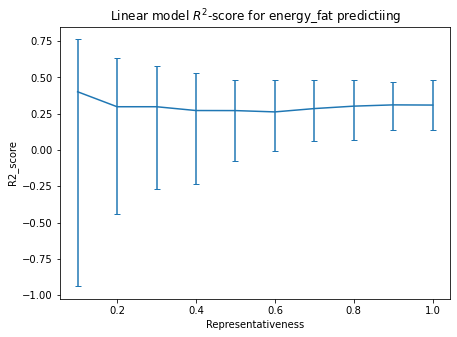

In [35]:
fog, ax = plt.subplots(1,1)
ax.errorbar(repres_vals, r2_estimators[target], 
             yerr = [r2_estimators[target] - r2_lower_CIs[target], - r2_estimators[target] + r2_upper_CIs[target]], 
             capsize= 3)
ax.set_xlabel('Representativeness')
ax.set_ylabel('R2_score')
ax.set_title(f'Linear model $R^2$-score for {target} predictiing')

Statistically significant features (with p-value < 0.05): Black or Black British, Asian or Asian British (etnicities), Jewish, Muslim, No religion (religions), Level 1 qualifications, Aged 0-15. More precisely, we see that amount of consumed energy from fats depends on:
1) Etnicity: less for Black or Black British, more for Asian or Asian British. <br>
2) Religion: less for Jewish, more for Muslim and people with no religion. <br>
3) Qualification: more for people with the lowest qualification. <br>
4) Age: more for children (age 0-15)

# Linear model for energy_saturate

In [36]:
target = 'energy_saturate'
df_enerfy_fat = get_label_summary(target, selected_cols_best[target])
df_enerfy_fat

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,31.9765,0.059,545.053,0.000,31.861,32.092
"Q(""Asian or Asian British"")",1.5893,0.233,6.829,0.000,1.132,2.047
"Q(""Muslim"")",0.7980,0.146,5.455,0.000,0.511,1.085
"Q(""White"")",1.8280,0.246,7.430,0.000,1.345,2.311
"Q(""Jewish"")",-0.3795,0.062,-6.091,0.000,-0.502,-0.257
"Q(""Aged 0-15"")",0.3670,0.085,4.333,0.000,0.201,0.533
"Q(""Mixed"")",0.3949,0.127,3.118,0.002,0.146,0.644


In [38]:
selected_cols_very_best[target] = [actual_name(col) for col in list(df_enerfy_fat.index) if col != 'Intercept']
n = len(df_ward_atlas)
r2_estimators[target] = []
r2_lower_CIs[target] = []
r2_upper_CIs[target] = []
for repres in repres_vals:
    num_samples = int(n * repres)
    r2_scores = get_r2_samples(target, selected_cols_very_best[target], df_ward_atlas[:num_samples])
    estimator, lower_CI, upper_CI = estimate_from_samples(r2_scores)
    print(f'repres = {repres},', estimator, lower_CI, upper_CI)
    r2_estimators[target].append(estimator)
    r2_lower_CIs[target].append(lower_CI)
    r2_upper_CIs[target].append(upper_CI)
r2_estimators[target] = np.array(r2_estimators[target])
r2_lower_CIs[target] = np.array(r2_lower_CIs[target])
r2_upper_CIs[target] = np.array(r2_upper_CIs[target])

repres = 0.1, 0.3138889998369945 -1.5410011068419172 0.7856036707065213
repres = 0.2, 0.15506438472108658 -0.6391806201981749 0.5576019141326605
repres = 0.30000000000000004, 0.18471369110475344 -0.39882044808582373 0.5349950820411348
repres = 0.4, 0.2192911449366397 -0.23838089520293648 0.5123853546537019
repres = 0.5, 0.20124805623996023 -0.1453289593949154 0.4216634448775757
repres = 0.6, 0.1676718252701046 -0.12883582392481174 0.40759845660338556
repres = 0.7000000000000001, 0.23594670100783177 0.005193127717747048 0.43669296920266154
repres = 0.8, 0.36533638072992486 0.12630153763674168 0.5820328085572135
repres = 0.9, 0.3253643333615529 0.11318825126780652 0.5380891783720136
repres = 1.0, 0.3210364311557834 0.1248359403704411 0.5338893788393364


Text(0.5, 1.0, 'Linear model $R^2$-score for energy_saturate predictiing')

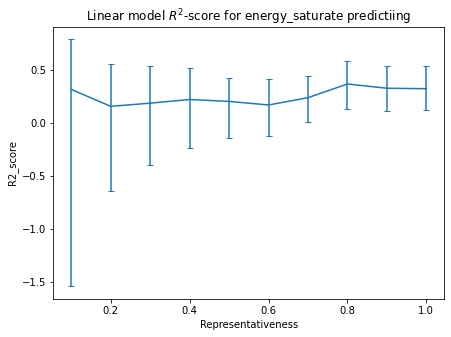

In [39]:
fog, ax = plt.subplots(1,1)
ax.errorbar(repres_vals, r2_estimators[target], 
             yerr = [r2_estimators[target] - r2_lower_CIs[target], - r2_estimators[target] + r2_upper_CIs[target]], 
             capsize= 3)
ax.set_xlabel('Representativeness')
ax.set_ylabel('R2_score')
ax.set_title(f'Linear model $R^2$-score for {target} predictiing')

# Linear model for energy_sugar

In [40]:
target = 'energy_sugar'
df_enerfy_fat = get_label_summary(target, selected_cols_best[target])
df_enerfy_fat

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,41.1431,0.114,360.409,0.000,40.919,41.367
"Q(""Level 1 qualifications"")",2.4278,0.335,7.237,0.000,1.769,3.087
"Q(""Mixed"")",-0.4886,0.202,-2.418,0.016,-0.886,-0.092
"Q(""IOD AVG"")",-1.1550,0.303,-3.818,0.000,-1.749,-0.561
"Q(""Asian or Asian British"")",2.4324,0.388,6.271,0.000,1.670,3.195
"Q(""No religion"")",0.9193,0.238,3.860,0.000,0.451,1.387
"Q(""Hindu"")",-0.9713,0.248,-3.918,0.000,-1.458,-0.484
"Q(""Sikh"")",-0.3959,0.147,-2.690,0.007,-0.685,-0.107
"Q(""Jewish"")",-0.2948,0.133,-2.216,0.027,-0.556,-0.033


In [41]:
selected_cols_very_best[target] = [actual_name(col) for col in list(df_enerfy_fat.index) if col != 'Intercept']
n = len(df_ward_atlas)
r2_estimators[target] = []
r2_lower_CIs[target] = []
r2_upper_CIs[target] = []
for repres in repres_vals:
    num_samples = int(n * repres)
    r2_scores = get_r2_samples(target, selected_cols_very_best[target], df_ward_atlas[:num_samples])
    estimator, lower_CI, upper_CI = estimate_from_samples(r2_scores)
    print(f'repres = {repres},', estimator, lower_CI, upper_CI)
    r2_estimators[target].append(estimator)
    r2_lower_CIs[target].append(lower_CI)
    r2_upper_CIs[target].append(upper_CI)
r2_estimators[target] = np.array(r2_estimators[target])
r2_lower_CIs[target] = np.array(r2_lower_CIs[target])
r2_upper_CIs[target] = np.array(r2_upper_CIs[target])

repres = 0.1, 0.415311559615136 -1.9476716655868165 0.7577433619280928
repres = 0.2, 0.5505941337605682 0.11214229063675651 0.7742034653232754
repres = 0.30000000000000004, 0.5702562310402086 0.2539090342808563 0.7606873613617617
repres = 0.4, 0.6061416783253335 0.3778038670356876 0.7529944494956341
repres = 0.5, 0.6613418887002966 0.48973564117264323 0.7813443458086305
repres = 0.6, 0.6469314766462699 0.36274054441757897 0.7708206580395562
repres = 0.7000000000000001, 0.6449254213920228 0.39228041462076424 0.7615032917148226
repres = 0.8, 0.6579033476886883 0.4118239030865469 0.7663983966422313
repres = 0.9, 0.6217135536465094 0.4104312097202639 0.7435117571371801
repres = 1.0, 0.6234135368037366 0.4196070624556105 0.728031595969


Text(0.5, 1.0, 'Linear model $R^2$-score for energy_sugar predictiing')

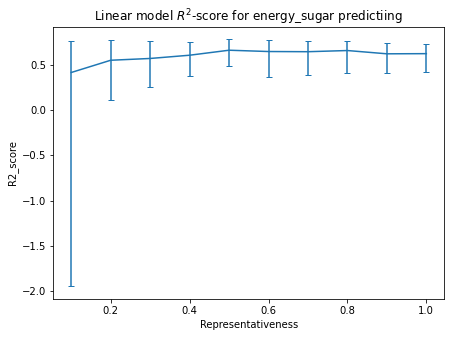

In [42]:
fog, ax = plt.subplots(1,1)
ax.errorbar(repres_vals, r2_estimators[target], 
             yerr = [r2_estimators[target] - r2_lower_CIs[target], - r2_estimators[target] + r2_upper_CIs[target]], 
             capsize= 3)
ax.set_xlabel('Representativeness')
ax.set_ylabel('R2_score')
ax.set_title(f'Linear model $R^2$-score for {target} predictiing')

# Linear model for energy_protein

In [43]:
target = 'energy_protein'
df_enerfy_fat = get_label_summary(target, selected_cols_best[target])
df_enerfy_fat

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,21.0690,0.027,787.505,0.0,21.016,21.122
"Q(""Asian or Asian British"")",-0.5504,0.047,-11.757,0.0,-0.642,-0.458
"Q(""Jewish"")",-0.2922,0.027,-10.695,0.0,-0.346,-0.239
"Q(""Level 2 qualifications"")",-0.1750,0.029,-6.089,0.0,-0.231,-0.119


In [44]:
selected_cols_very_best[target] = [actual_name(col) for col in list(df_enerfy_fat.index) if col != 'Intercept']
n = len(df_ward_atlas)
r2_estimators[target] = []
r2_lower_CIs[target] = []
r2_upper_CIs[target] = []
for repres in repres_vals:
    num_samples = int(n * repres)
    r2_scores = get_r2_samples(target, selected_cols_very_best[target], df_ward_atlas[:num_samples])
    estimator, lower_CI, upper_CI = estimate_from_samples(r2_scores)
    print(f'repres = {repres},', estimator, lower_CI, upper_CI)
    r2_estimators[target].append(estimator)
    r2_lower_CIs[target].append(lower_CI)
    r2_upper_CIs[target].append(upper_CI)
r2_estimators[target] = np.array(r2_estimators[target])
r2_lower_CIs[target] = np.array(r2_lower_CIs[target])
r2_upper_CIs[target] = np.array(r2_upper_CIs[target])

repres = 0.1, 0.4468428376477297 -1.3673586351148033 0.7557015925882825
repres = 0.2, 0.4708463065744406 -0.21657719663569708 0.7086448020915418
repres = 0.30000000000000004, 0.5047235768155525 0.07173778583428159 0.7197087121151249
repres = 0.4, 0.5356269128640151 0.18525113671808846 0.7179213536370161
repres = 0.5, 0.6214692029476858 0.3635928828786781 0.7574358353967857
repres = 0.6, 0.5821454828679693 0.3446961817382913 0.7312465363409153
repres = 0.7000000000000001, 0.5730047203365699 0.3588432440134266 0.7079886562133366
repres = 0.8, 0.6034708735514493 0.41193334886625554 0.7184110900428633
repres = 0.9, 0.5660797609309945 0.3831313787228593 0.6875177598347906
repres = 1.0, 0.551444838274951 0.37442508536904506 0.6724312158075956


Text(0.5, 1.0, 'Linear model $R^2$-score for energy_protein predictiing')

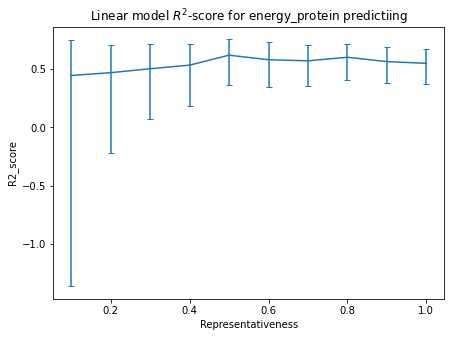

In [45]:
fog, ax = plt.subplots(1,1)
ax.errorbar(repres_vals, r2_estimators[target], 
             yerr = [r2_estimators[target] - r2_lower_CIs[target], - r2_estimators[target] + r2_upper_CIs[target]], 
             capsize= 3)
ax.set_xlabel('Representativeness')
ax.set_ylabel('R2_score')
ax.set_title(f'Linear model $R^2$-score for {target} predictiing')

# Linear model for energy_carb

In [46]:
target = 'energy_carb'
df_enerfy_fat = get_label_summary(target, selected_cols_best[target])
df_enerfy_fat

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,73.0494,0.123,591.544,0.000,72.807,73.292
"Q(""Level 1 qualifications"")",1.4988,0.432,3.472,0.001,0.651,2.347
"Q(""Asian or Asian British"")",0.8307,0.394,2.111,0.035,0.057,1.604
"Q(""Born in UK"")",0.9883,0.349,2.829,0.005,0.302,1.675
"Q(""Jewish"")",-0.9322,0.182,-5.124,0.000,-1.290,-0.575
"Q(""Household Income Median"")",-1.0000,0.293,-3.418,0.001,-1.575,-0.425
"Q(""Muslim"")",0.6509,0.245,2.655,0.008,0.169,1.133
"Q(""Mixed"")",-0.9457,0.224,-4.228,0.000,-1.385,-0.506
"Q(""Level 2 qualifications"")",1.8591,0.475,3.915,0.000,0.926,2.792


In [47]:
selected_cols_very_best[target] = [actual_name(col) for col in list(df_enerfy_fat.index) if col != 'Intercept']
n = len(df_ward_atlas)
r2_estimators[target] = []
r2_lower_CIs[target] = []
r2_upper_CIs[target] = []
for repres in repres_vals:
    num_samples = int(n * repres)
    r2_scores = get_r2_samples(target, selected_cols_very_best[target], df_ward_atlas[:num_samples])
    estimator, lower_CI, upper_CI = estimate_from_samples(r2_scores)
    print(f'repres = {repres},', estimator, lower_CI, upper_CI)
    r2_estimators[target].append(estimator)
    r2_lower_CIs[target].append(lower_CI)
    r2_upper_CIs[target].append(upper_CI)
r2_estimators[target] = np.array(r2_estimators[target])
r2_lower_CIs[target] = np.array(r2_lower_CIs[target])
r2_upper_CIs[target] = np.array(r2_upper_CIs[target])

repres = 0.1, 0.759229722915987 0.34979996618571074 0.9077090158975331
repres = 0.2, 0.8141541170023576 0.6145960408940536 0.9019246459660616
repres = 0.30000000000000004, 0.8134315278708762 0.6727942189976934 0.8913965035858337
repres = 0.4, 0.8202942873165836 0.7191667798546921 0.8813649867088129
repres = 0.5, 0.821451370703998 0.720216361160371 0.8804969276268954
repres = 0.6, 0.7936967586329199 0.6824675598923693 0.8703974596967127
repres = 0.7000000000000001, 0.7853491387322507 0.6897653786417393 0.854906496429565
repres = 0.8, 0.7900673968516053 0.7028443701194111 0.8581198883005678
repres = 0.9, 0.7677360065095546 0.6713004207449649 0.8331872074900026
repres = 1.0, 0.7643255275320018 0.6861892817161701 0.8285190684879483


Text(0.5, 1.0, 'Linear model $R^2$-score for energy_carb predictiing')

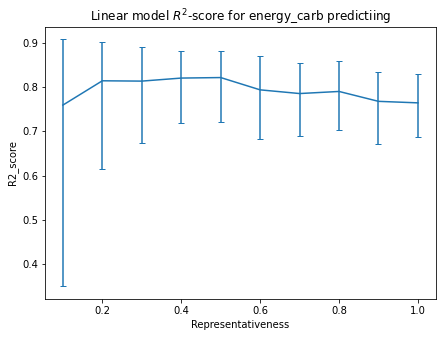

In [48]:
fog, ax = plt.subplots(1,1)
ax.errorbar(repres_vals, r2_estimators[target], 
             yerr = [r2_estimators[target] - r2_lower_CIs[target], - r2_estimators[target] + r2_upper_CIs[target]], 
             capsize= 3)
ax.set_xlabel('Representativeness')
ax.set_ylabel('R2_score')
ax.set_title(f'Linear model $R^2$-score for {target} predictiing')

Statistically significant features (with p-value < 0.05): White, Mixed (etnicities), Jewish (religion), Born in UK, Limited activities, Level >=4 qualifications (i. e. maximum level of qualification). More precisely, we see that amount of energy consumed from carbohidrates depends on:
1) Etnicity: less for white and (especially) mixed people than in average
2) Religion: less for Jewish people
3) Place of birth: more for people born in UK than for those who were born abroad
4) Health state: less for people whose Day-to-day activities are limited a lot
5) Qualification: less for highly qualified people, more for low qualified. Here results for 'No qualifications' may be skewed, because this category probably includes all children independently of their mental abilities.

# Linear model for energy_fibre

In [49]:
target = 'energy_fibre'
df_enerfy_fat = get_label_summary(target, selected_cols_best[target])
df_enerfy_fat

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,3.0450,0.004,714.654,0.000,3.037,3.053
"Q(""IOD AVG"")",-0.0560,0.010,-5.489,0.000,-0.076,-0.036
"Q(""Black or Black British"")",-0.0535,0.023,-2.339,0.020,-0.099,-0.009
"Q(""Sikh"")",0.0356,0.005,7.041,0.000,0.026,0.045
"Q(""Level 1 qualifications"")",-0.0806,0.018,-4.599,0.000,-0.115,-0.046
"Q(""Asian or Asian British"")",-0.0680,0.030,-2.277,0.023,-0.127,-0.009
"Q(""Household Income Median"")",-0.0378,0.012,-3.230,0.001,-0.061,-0.015


In [50]:
selected_cols_very_best[target] = [actual_name(col) for col in list(df_enerfy_fat.index) if col != 'Intercept']
n = len(df_ward_atlas)
r2_estimators[target] = []
r2_lower_CIs[target] = []
r2_upper_CIs[target] = []
for repres in repres_vals:
    num_samples = int(n * repres)
    r2_scores = get_r2_samples(target, selected_cols_very_best[target], df_ward_atlas[:num_samples])
    estimator, lower_CI, upper_CI = estimate_from_samples(r2_scores)
    print(f'repres = {repres},', estimator, lower_CI, upper_CI)
    r2_estimators[target].append(estimator)
    r2_lower_CIs[target].append(lower_CI)
    r2_upper_CIs[target].append(upper_CI)
r2_estimators[target] = np.array(r2_estimators[target])
r2_lower_CIs[target] = np.array(r2_lower_CIs[target])
r2_upper_CIs[target] = np.array(r2_upper_CIs[target])

repres = 0.1, 0.30044920937473507 -0.7457291196660236 0.812549163294913
repres = 0.2, 0.48407570740634076 0.004456648499085114 0.7560804811769573
repres = 0.30000000000000004, 0.46062256638893284 0.108485445633137 0.69374053201509
repres = 0.4, 0.4908537718804166 0.2253947443921137 0.687388801307982
repres = 0.5, 0.49440257080106337 0.2723314460071835 0.6592635352042089
repres = 0.6, 0.4551575376516348 0.23497851610454334 0.6046007820930371
repres = 0.7000000000000001, 0.49614610819129223 0.29843526676935583 0.6287446387570896
repres = 0.8, 0.5664707798269175 0.40416386425369555 0.6861314082184741
repres = 0.9, 0.5866881396849704 0.4398181590383844 0.6976499897782187
repres = 1.0, 0.5822551233529378 0.4399453604453608 0.6894042658589188


Text(0.5, 1.0, 'Linear model $R^2$-score for energy_fibre predictiing')

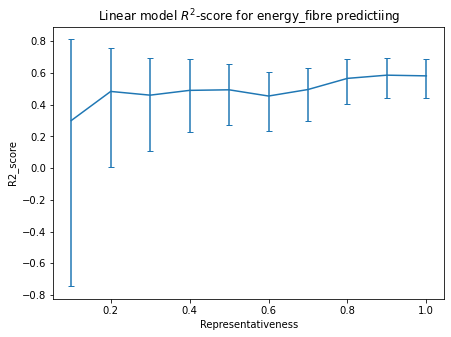

In [51]:
fog, ax = plt.subplots(1,1)
ax.errorbar(repres_vals, r2_estimators[target], 
             yerr = [r2_estimators[target] - r2_lower_CIs[target], - r2_estimators[target] + r2_upper_CIs[target]], 
             capsize= 3)
ax.set_xlabel('Representativeness')
ax.set_ylabel('R2_score')
ax.set_title(f'Linear model $R^2$-score for {target} predictiing')

# Linear model for energy_alcohol

In [54]:
target = 'energy_alcohol'
df_enerfy_fat = get_label_summary(target, selected_cols_best[target])
df_enerfy_fat

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.6577,0.013,129.685,0.0,1.633,1.683
"Q(""Level >=4 qualifications"")",0.1831,0.015,12.341,0.0,0.154,0.212
"Q(""Muslim"")",-0.1413,0.023,-6.084,0.0,-0.187,-0.096
"Q(""Jewish"")",-0.0543,0.015,-3.678,0.0,-0.083,-0.025
"Q(""IOD AVG"")",0.0602,0.017,3.526,0.0,0.027,0.094


In [55]:
selected_cols_very_best[target] = [actual_name(col) for col in list(df_enerfy_fat.index) if col != 'Intercept']
n = len(df_ward_atlas)
r2_estimators[target] = []
r2_lower_CIs[target] = []
r2_upper_CIs[target] = []
for repres in repres_vals:
    num_samples = int(n * repres)
    r2_scores = get_r2_samples(target, selected_cols_very_best[target], df_ward_atlas[:num_samples])
    estimator, lower_CI, upper_CI = estimate_from_samples(r2_scores)
    print(f'repres = {repres},', estimator, lower_CI, upper_CI)
    r2_estimators[target].append(estimator)
    r2_lower_CIs[target].append(lower_CI)
    r2_upper_CIs[target].append(upper_CI)
r2_estimators[target] = np.array(r2_estimators[target])
r2_lower_CIs[target] = np.array(r2_lower_CIs[target])
r2_upper_CIs[target] = np.array(r2_upper_CIs[target])

repres = 0.1, 0.2083034420925272 -1.3137185451953486 0.5581570482979143
repres = 0.2, 0.36408878513438464 -0.16269031694300362 0.6187164908590675
repres = 0.30000000000000004, 0.2860255165973823 -0.06631409013827172 0.4883464663496234
repres = 0.4, 0.37786430869540966 0.0625373736061754 0.5650710925754432
repres = 0.5, 0.37887428019143277 0.12648168791140335 0.5336839125208463
repres = 0.6, 0.3657363619865863 0.1663699402492912 0.5115562174542261
repres = 0.7000000000000001, 0.3262222107757805 0.11702486395853517 0.4726578717486587
repres = 0.8, 0.3663120781058519 0.18216369505969499 0.5012001838761129
repres = 0.9, 0.3669765735860637 0.1724412003538338 0.49666482877513296
repres = 1.0, 0.3821229294990842 0.22473180437801477 0.5093891943189996


Text(0.5, 1.0, 'Linear model $R^2$-score for energy_alcohol predictiing')

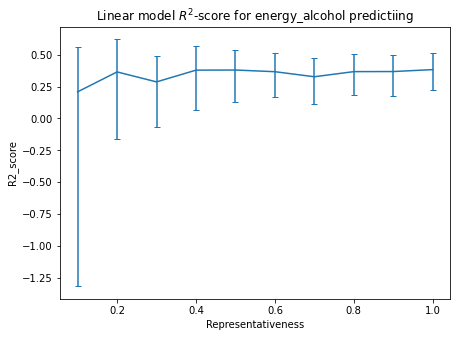

In [56]:
fog, ax = plt.subplots(1,1)
ax.errorbar(repres_vals, r2_estimators[target], 
             yerr = [r2_estimators[target] - r2_lower_CIs[target], - r2_estimators[target] + r2_upper_CIs[target]], 
             capsize= 3)
ax.set_xlabel('Representativeness')
ax.set_ylabel('R2_score')
ax.set_title(f'Linear model $R^2$-score for {target} predictiing')

# Linear model for energy_tot

In [57]:
target = 'energy_tot'
df_enerfy_fat = get_label_summary(target, selected_cols_best[target])
df_enerfy_fat

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,180.0912,0.212,851.441,0.000,179.676,180.507
"Q(""Level 1 qualifications"")",3.6468,0.369,9.875,0.000,2.921,4.372
"Q(""Jewish"")",-2.2548,0.219,-10.276,0.000,-2.686,-1.824
"Q(""Mixed"")",-2.3628,0.261,-9.050,0.000,-2.876,-1.850
"Q(""Household Income Median"")",-1.0770,0.377,-2.858,0.004,-1.817,-0.337


In [58]:
selected_cols_very_best[target] = [actual_name(col) for col in list(df_enerfy_fat.index) if col != 'Intercept']
n = len(df_ward_atlas)
r2_estimators[target] = []
r2_lower_CIs[target] = []
r2_upper_CIs[target] = []
for repres in repres_vals:
    num_samples = int(n * repres)
    r2_scores = get_r2_samples(target, selected_cols_very_best[target], df_ward_atlas[:num_samples])
    estimator, lower_CI, upper_CI = estimate_from_samples(r2_scores)
    print(f'repres = {repres},', estimator, lower_CI, upper_CI)
    r2_estimators[target].append(estimator)
    r2_lower_CIs[target].append(lower_CI)
    r2_upper_CIs[target].append(upper_CI)
r2_estimators[target] = np.array(r2_estimators[target])
r2_lower_CIs[target] = np.array(r2_lower_CIs[target])
r2_upper_CIs[target] = np.array(r2_upper_CIs[target])

repres = 0.1, 0.8010423302171796 0.49703420471973725 0.9301162186014276
repres = 0.2, 0.7694607351649364 0.527192326484349 0.8882329138823194
repres = 0.30000000000000004, 0.7522198737168699 0.544261564773393 0.8597640504619983
repres = 0.4, 0.7152411378241537 0.5480319074076372 0.8173227490360336
repres = 0.5, 0.7226808466449581 0.5777877196331959 0.8071957443267915
repres = 0.6, 0.6837895117735191 0.4784338761704632 0.7957485433901181
repres = 0.7000000000000001, 0.6701094257718692 0.48747760758592196 0.7878037125070262
repres = 0.8, 0.6542935659821357 0.49290981929668454 0.7654881930124853
repres = 0.9, 0.614913096218644 0.4690428746893126 0.7304581262312942
repres = 1.0, 0.6306629944160835 0.4933106089782042 0.7331275754605281


Text(0.5, 1.0, 'Linear model $R^2$-score for energy_tot predictiing')

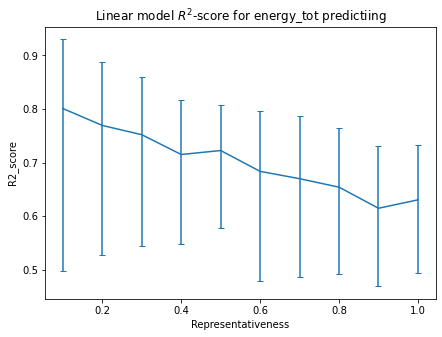

In [59]:
fog, ax = plt.subplots(1,1)
ax.errorbar(repres_vals, r2_estimators[target], 
             yerr = [r2_estimators[target] - r2_lower_CIs[target], - r2_estimators[target] + r2_upper_CIs[target]], 
             capsize= 3)
ax.set_xlabel('Representativeness')
ax.set_ylabel('R2_score')
ax.set_title(f'Linear model $R^2$-score for {target} predictiing')

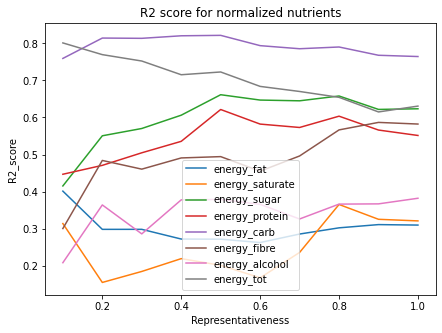

In [60]:
fog, ax = plt.subplots(1,1)
for nutrient in r2_estimators.keys():
    ax.plot(repres_vals, r2_estimators[nutrient], label=nutrient)
ax.set_xlabel('Representativeness')
ax.set_ylabel('R2_score')
ax.set_title(f'R2 score for energy nutrients')
ax.legend()
plt.show()

# Predicting a fraction of each nutrient energy

In [ ]:
target_cols = ['f_energy_fat', 'f_energy_saturate', 
                 'f_energy_sugar', 'f_energy_protein', 'f_energy_carb', 'f_energy_fibre', 'f_energy_alcohol']
global_test_best = {}
selected_cols_best = {}
energy_corr = {}
for y in target_cols:
    energy_corr[y] = df_ward_atlas[all_features].corrwith(df_ward_atlas[y], method='pearson')
    energy_corr[y] = energy_corr[y].sort_values(ascending=False, key=np.abs)
    #get rid of linearly dependent cols
    for cols in [age_cols, ethnicities_cols, religion_cols, born_cols, qualilication_cols]:
        energy_corr[y].drop(energy_corr[y][cols].index[-1], axis=0, inplace=True)
    global_test_best[y], selected_cols_best[y]  = forward_feature_selection_brute_force(energy_corr[y], y)
    print('{}: best r2 score = {:.5f}, num features = {}'.format(y, global_test_best[y], len(selected_cols_best[y])))

In [42]:
f = open("r2_scores_fen.pkl","wb")
pickle.dump(global_test_best,f)
f.close()
f = open("selected_cols_fen.pkl","wb")
pickle.dump(selected_cols_best,f)
f.close()

In [24]:
f = open("r2_scores_fen.pkl","rb")
global_test_best = pickle.load(f)
f.close()
f = open("selected_cols_fen.pkl","rb")
selected_cols_best = pickle.load(f)
f.close()

In [85]:
selected_cols_very_best = {}
r2_estimators = {}
r2_lower_CIs = {}
r2_upper_CIs = {}
repres_vals = np.linspace(0.1,1,10)

In [30]:
df_ward_atlas = df_ward_atlas.sort_values(by='representativeness_norm', ascending=False)

# Linear model for f_energy_fat

In [35]:
target = 'f_energy_fat'
df_enerfy_fat = get_label_summary(target, selected_cols_best[target])
df_enerfy_fat

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.4515,0.000,1209.733,0.000,0.451,0.452
"Q(""Level 2 qualifications"")",-0.0083,0.000,-17.888,0.000,-0.009,-0.007
"Q(""Black or Black British"")",-0.0026,0.000,-5.615,0.000,-0.003,-0.002
"Q(""Aged 0-15"")",0.0017,0.001,3.226,0.001,0.001,0.003


In [87]:
df_enerfy_fat = get_label_summary(target, selected_cols_very_best[target])
df_enerfy_fat

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.4515,0.000,1209.733,0.000,0.451,0.452
"Q(""Level 2 qualifications"")",-0.0083,0.000,-17.888,0.000,-0.009,-0.007
"Q(""Black or Black British"")",-0.0026,0.000,-5.615,0.000,-0.003,-0.002
"Q(""Aged 0-15"")",0.0017,0.001,3.226,0.001,0.001,0.003


In [86]:
selected_cols_very_best[target] = [actual_name(col) for col in list(df_enerfy_fat.index) if col != 'Intercept']
n = len(df_ward_atlas)
r2_estimators[target] = []
r2_lower_CIs[target] = []
r2_upper_CIs[target] = []
for repres in repres_vals:
    num_samples = int(n * repres)
    r2_scores = get_r2_samples(target, selected_cols_very_best[target], df_ward_atlas[:num_samples])
    estimator, lower_CI, upper_CI = estimate_from_samples(r2_scores)
    print(f'repres = {repres},', estimator, lower_CI, upper_CI)
    r2_estimators[target].append(estimator)
    r2_lower_CIs[target].append(lower_CI)
    r2_upper_CIs[target].append(upper_CI)
r2_estimators[target] = np.array(r2_estimators[target])
r2_lower_CIs[target] = np.array(r2_lower_CIs[target])
r2_upper_CIs[target] = np.array(r2_upper_CIs[target])

repres = 0.1, 0.6028867507813203 -0.3977748190908583 0.8671790031875277
repres = 0.2, 0.5255109362700828 0.033306416074178946 0.7428129304761846
repres = 0.30000000000000004, 0.5069400741945398 0.12515210184727177 0.7141923763537741
repres = 0.4, 0.5316146615962866 0.2720287853328244 0.698749607417501
repres = 0.5, 0.5180544250973406 0.28557634873229076 0.667564093823978
repres = 0.6, 0.5218888006919535 0.3304210231110205 0.6538001671209343
repres = 0.7000000000000001, 0.530349658218568 0.3435389628528571 0.6503021636328208
repres = 0.8, 0.5266487352014199 0.35848227231350704 0.6422083471109996
repres = 0.9, 0.4829546019988966 0.28835358348952944 0.619588234804157
repres = 1.0, 0.4402185861938559 0.2705610037827012 0.5857494412612854


Text(0.5, 1.0, 'Linear model $R^2$-score for f_energy_fat predictiing')

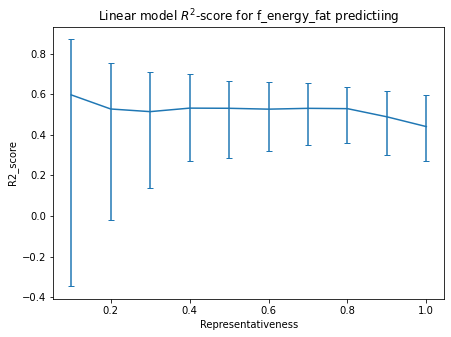

In [83]:
fog, ax = plt.subplots(1,1)
ax.errorbar(repres_vals, r2_estimators[target], 
             yerr = [r2_estimators[target] - r2_lower_CIs[target], - r2_estimators[target] + r2_upper_CIs[target]], 
             capsize= 3)
ax.set_xlabel('Representativeness')
ax.set_ylabel('R2_score')
ax.set_title(f'Linear model $R^2$-score for {target} predictiing')

Statistically significant features (with p-value < 0.05) are: Level 2 qualifications, Black or Black British, Born in UK, Aged 0-15, and Hindu. Thus, we see that the fraction of fat in consumed consumed food depends on:

1) Qualification: people with low qualification tend to consume more fat <br>
2) Etnicity: Black or Black British people tend to consume less fat <br>
3) Place of birth: people born in UK tend to consume less fat <br>
4) 

# Linear model for f_energy_saturate

In [91]:
target = 'f_energy_saturate'
df_enerfy_fat = get_label_summary(target, selected_cols_best[target])
df_enerfy_fat

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.1775,0.000,728.678,0.000,0.177,0.178
"Q(""Level 2 qualifications"")",-0.0025,0.001,-2.530,0.012,-0.005,-0.001
"Q(""Black or Black British"")",-0.0039,0.001,-7.265,0.000,-0.005,-0.003
"Q(""Mixed"")",0.0024,0.000,5.002,0.000,0.001,0.003
"Q(""Muslim"")",0.0024,0.001,4.491,0.000,0.001,0.003
"Q(""Level 3 qualifications"")",-0.0007,0.000,-2.736,0.006,-0.001,-0.000
"Q(""Other religions"")",0.0008,0.000,2.995,0.003,0.000,0.001


In [92]:
selected_cols_very_best[target] = [actual_name(col) for col in list(df_enerfy_fat.index) if col != 'Intercept']
n = len(df_ward_atlas)
r2_estimators[target] = []
r2_lower_CIs[target] = []
r2_upper_CIs[target] = []
for repres in repres_vals:
    num_samples = int(n * repres)
    r2_scores = get_r2_samples(target, selected_cols_very_best[target], df_ward_atlas[:num_samples])
    estimator, lower_CI, upper_CI = estimate_from_samples(r2_scores)
    print(f'repres = {repres},', estimator, lower_CI, upper_CI)
    r2_estimators[target].append(estimator)
    r2_lower_CIs[target].append(lower_CI)
    r2_upper_CIs[target].append(upper_CI)
r2_estimators[target] = np.array(r2_estimators[target])
r2_lower_CIs[target] = np.array(r2_lower_CIs[target])
r2_upper_CIs[target] = np.array(r2_upper_CIs[target])

repres = 0.1, 0.43134850082017095 -0.48528581117107006 0.8154983536042127
repres = 0.2, 0.4900014267521113 -0.12125458082907414 0.7398642697105714
repres = 0.30000000000000004, 0.5340617005853077 0.20553306992667908 0.7261892471718202
repres = 0.4, 0.5881996703685405 0.33931393171306046 0.7432118869118214
repres = 0.5, 0.5788811200345975 0.37538675039051694 0.7151784116630511
repres = 0.6, 0.5310774737310738 0.2748722046461348 0.6658431963849254
repres = 0.7000000000000001, 0.5170942789714381 0.3159103761262979 0.6398629522938514
repres = 0.8, 0.4907498735204034 0.3155281792816895 0.6168709160090633
repres = 0.9, 0.4640563887823126 0.2757369669082529 0.5990245770853434
repres = 1.0, 0.4186481191096478 0.2583474315089721 0.5554479261630199


Text(0.5, 1.0, 'Linear model $R^2$-score for f_energy_saturate predictiing')

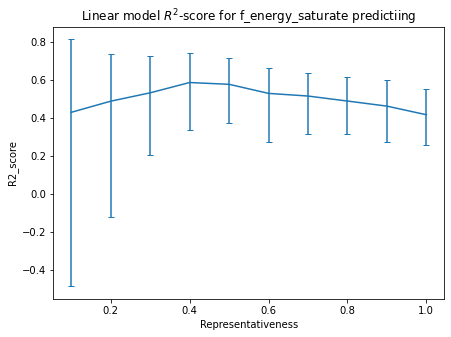

In [93]:
fog, ax = plt.subplots(1,1)
ax.errorbar(repres_vals, r2_estimators[target], 
             yerr = [r2_estimators[target] - r2_lower_CIs[target], - r2_estimators[target] + r2_upper_CIs[target]], 
             capsize= 3)
ax.set_xlabel('Representativeness')
ax.set_ylabel('R2_score')
ax.set_title(f'Linear model $R^2$-score for {target} predictiing')

In [ ]:
fog, ax = plt.subplots(1,1)
for nutrient in r2_estimators.keys():
    ax.plot(repres_vals, r2_estimators[nutrient], label=nutrient)
ax.set_xlabel('Representativeness')
ax.set_ylabel('R2_score')
ax.set_title(f'R2 score for утукпн nutrients')
ax.legend()
plt.show()

# Linear model for f_energy_sugar

In [97]:
target = 'f_energy_sugar'
df_enerfy_fat = get_label_summary(target, selected_cols_best[target])
df_enerfy_fat

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.2275,0.000,472.135,0.0,0.227,0.228
"Q(""Asian or Asian British"")",0.0085,0.002,5.285,0.0,0.005,0.012
"Q(""White"")",0.0079,0.002,4.105,0.0,0.004,0.012
"Q(""Level 1 qualifications"")",0.0066,0.002,4.203,0.0,0.004,0.010


In [95]:
selected_cols_very_best[target] = [actual_name(col) for col in list(df_enerfy_fat.index) if col != 'Intercept']
n = len(df_ward_atlas)
r2_estimators[target] = []
r2_lower_CIs[target] = []
r2_upper_CIs[target] = []
for repres in repres_vals:
    num_samples = int(n * repres)
    r2_scores = get_r2_samples(target, selected_cols_very_best[target], df_ward_atlas[:num_samples])
    estimator, lower_CI, upper_CI = estimate_from_samples(r2_scores)
    print(f'repres = {repres},', estimator, lower_CI, upper_CI)
    r2_estimators[target].append(estimator)
    r2_lower_CIs[target].append(lower_CI)
    r2_upper_CIs[target].append(upper_CI)
r2_estimators[target] = np.array(r2_estimators[target])
r2_lower_CIs[target] = np.array(r2_lower_CIs[target])
r2_upper_CIs[target] = np.array(r2_upper_CIs[target])

repres = 0.1, 0.23761677078617954 -1.139533733261561 0.6341905493371464
repres = 0.2, 0.25089134084483367 -0.23757031590463673 0.5418379501004635
repres = 0.30000000000000004, 0.3482341752234135 -0.0059818151685637755 0.5845906749022809
repres = 0.4, 0.33543656977109065 0.03884002128147146 0.527390576874929
repres = 0.5, 0.33455611500646387 0.11001603077644728 0.5026528493289443
repres = 0.6, 0.3134862594589328 0.0703553853401323 0.466651567853121
repres = 0.7000000000000001, 0.32046140707588383 0.14851774075151458 0.46228707002073044
repres = 0.8, 0.35955520159420407 0.19020641587286535 0.4983330082501505
repres = 0.9, 0.3935435199658458 0.25992572442764805 0.5270222618750344
repres = 1.0, 0.4156194901332853 0.28788009753846233 0.5425782011332253


Text(0.5, 1.0, 'Linear model $R^2$-score for f_energy_sugar predictiing')

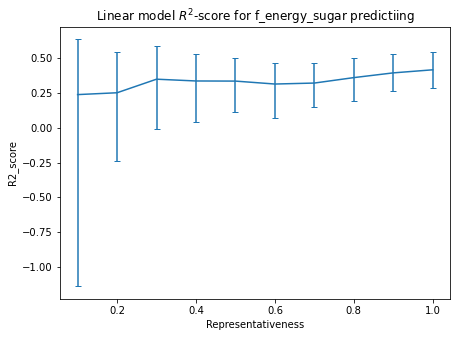

In [96]:
fog, ax = plt.subplots(1,1)
ax.errorbar(repres_vals, r2_estimators[target], 
             yerr = [r2_estimators[target] - r2_lower_CIs[target], - r2_estimators[target] + r2_upper_CIs[target]], 
             capsize= 3)
ax.set_xlabel('Representativeness')
ax.set_ylabel('R2_score')
ax.set_title(f'Linear model $R^2$-score for {target} predictiing')

# Linear model for f_energy_protein

In [106]:
target = 'f_energy_protein'
df_enerfy_fat = get_label_summary(target, selected_cols_best[target])
df_enerfy_fat

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.1171,0.000,640.855,0.000,0.117,0.11700
"Q(""Level >=4 qualifications"")",0.0022,0.001,2.456,0.014,0.000,0.00400
"Q(""Asian or Asian British"")",-0.0057,0.000,-12.036,0.000,-0.007,-0.00500
"Q(""Aged 0-15"")",-0.0009,0.000,-2.140,0.033,-0.002,-0.00007
"Q(""Mixed"")",0.0011,0.000,3.463,0.001,0.000,0.00200
"Q(""Sikh"")",0.0010,0.000,4.946,0.000,0.001,0.00100
"Q(""No religion"")",-0.0029,0.001,-5.124,0.000,-0.004,-0.00200
"Q(""Buddhist"")",0.0008,0.000,3.642,0.000,0.000,0.00100
"Q(""Level 1 qualifications"")",-0.0028,0.001,-2.943,0.003,-0.005,-0.00100


In [98]:
selected_cols_very_best[target] = [actual_name(col) for col in list(df_enerfy_fat.index) if col != 'Intercept']
n = len(df_ward_atlas)
r2_estimators[target] = []
r2_lower_CIs[target] = []
r2_upper_CIs[target] = []
for repres in repres_vals:
    num_samples = int(n * repres)
    r2_scores = get_r2_samples(target, selected_cols_very_best[target], df_ward_atlas[:num_samples])
    estimator, lower_CI, upper_CI = estimate_from_samples(r2_scores)
    print(f'repres = {repres},', estimator, lower_CI, upper_CI)
    r2_estimators[target].append(estimator)
    r2_lower_CIs[target].append(lower_CI)
    r2_upper_CIs[target].append(upper_CI)
r2_estimators[target] = np.array(r2_estimators[target])
r2_lower_CIs[target] = np.array(r2_lower_CIs[target])
r2_upper_CIs[target] = np.array(r2_upper_CIs[target])

repres = 0.1, 0.20128759447362715 -1.065900970205838 0.6289381245644468
repres = 0.2, 0.24828905442239185 -0.19990563006314988 0.5486244086676674
repres = 0.30000000000000004, 0.3457529373393594 -0.018641908692578646 0.5779530445223257
repres = 0.4, 0.3289814912024699 0.058306727452988705 0.5232448858475164
repres = 0.5, 0.34031322074877146 0.10634783037386264 0.49963205750915374
repres = 0.6, 0.3222886594461027 0.10341426852978453 0.47122414675789825
repres = 0.7000000000000001, 0.32048562299773464 0.13312242862948787 0.4586669212418505
repres = 0.8, 0.3642161448225081 0.2015460370359632 0.48817862945749335
repres = 0.9, 0.39539009745879944 0.2631600017750533 0.5363763316941219
repres = 1.0, 0.41414082980961103 0.2839741817490913 0.5391003500369442


Text(0.5, 1.0, 'Linear model $R^2$-score for f_energy_sugar predictiing')

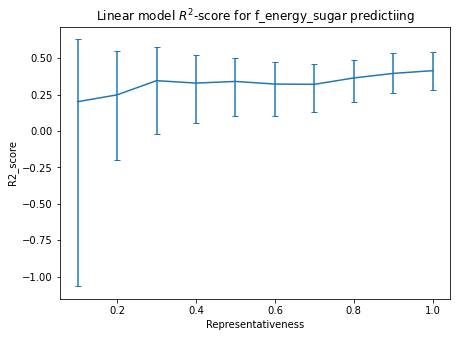

In [99]:
fog, ax = plt.subplots(1,1)
ax.errorbar(repres_vals, r2_estimators[target], 
             yerr = [r2_estimators[target] - r2_lower_CIs[target], - r2_estimators[target] + r2_upper_CIs[target]], 
             capsize= 3)
ax.set_xlabel('Representativeness')
ax.set_ylabel('R2_score')
ax.set_title(f'Linear model $R^2$-score for {target} predictiing')

# Linear model for f_energy_carb

In [101]:
target = 'f_energy_carb'
df_enerfy_fat = get_label_summary(target, selected_cols_best[target])
df_enerfy_fat

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.4048,0.000,965.205,0.000,0.404,0.406
"Q(""Level 1 qualifications"")",0.0059,0.001,4.079,0.000,0.003,0.009
"Q(""Hindu"")",0.0032,0.001,4.206,0.000,0.002,0.005
"Q(""Level 2 qualifications"")",0.0074,0.001,4.957,0.000,0.004,0.010
"Q(""Muslim"")",0.0025,0.001,2.368,0.018,0.000,0.005


In [102]:
selected_cols_very_best[target] = [actual_name(col) for col in list(df_enerfy_fat.index) if col != 'Intercept']
n = len(df_ward_atlas)
r2_estimators[target] = []
r2_lower_CIs[target] = []
r2_upper_CIs[target] = []
for repres in repres_vals:
    num_samples = int(n * repres)
    r2_scores = get_r2_samples(target, selected_cols_very_best[target], df_ward_atlas[:num_samples])
    estimator, lower_CI, upper_CI = estimate_from_samples(r2_scores)
    print(f'repres = {repres},', estimator, lower_CI, upper_CI)
    r2_estimators[target].append(estimator)
    r2_lower_CIs[target].append(lower_CI)
    r2_upper_CIs[target].append(upper_CI)
r2_estimators[target] = np.array(r2_estimators[target])
r2_lower_CIs[target] = np.array(r2_lower_CIs[target])
r2_upper_CIs[target] = np.array(r2_upper_CIs[target])

repres = 0.1, 0.7206856459078865 -0.4645922824607043 0.9223746830902557
repres = 0.2, 0.7628739522679139 0.4232748347704205 0.8811311250757163
repres = 0.30000000000000004, 0.7734457645640813 0.5698892679372605 0.866862122818933
repres = 0.4, 0.7721507965305544 0.6095073620394889 0.8556910547068857
repres = 0.5, 0.7618786906664556 0.6413586624720076 0.8405967767835273
repres = 0.6, 0.7515041348543112 0.6415473875709008 0.8246433606641987
repres = 0.7000000000000001, 0.7428810201317447 0.6366087174310041 0.8110921031953213
repres = 0.8, 0.729550317974073 0.6178835051155253 0.7953854436749275
repres = 0.9, 0.7206533398527996 0.6249645088781655 0.788100014067108
repres = 1.0, 0.6978524010588323 0.597558668181833 0.7728900321444384


Text(0.5, 1.0, 'Linear model $R^2$-score for f_energy_carb predictiing')

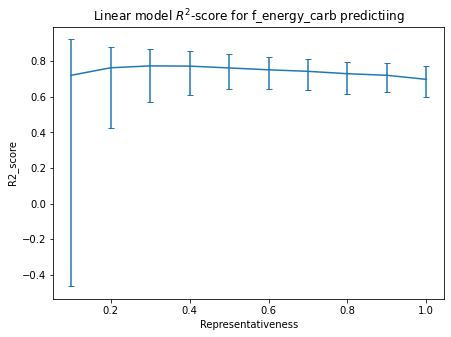

In [103]:
fog, ax = plt.subplots(1,1)
ax.errorbar(repres_vals, r2_estimators[target], 
             yerr = [r2_estimators[target] - r2_lower_CIs[target], - r2_estimators[target] + r2_upper_CIs[target]], 
             capsize= 3)
ax.set_xlabel('Representativeness')
ax.set_ylabel('R2_score')
ax.set_title(f'Linear model $R^2$-score for {target} predictiing')

# Linear model for f_energy_fibre

In [104]:
target = 'f_energy_fibre'
df_enerfy_fat = get_label_summary(target, selected_cols_best[target])
df_enerfy_fat

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.017000,0.000024,715.225,0.000,0.017000,0.017
"Q(""IOD AVG"")",-0.000400,0.000049,-7.640,0.000,-0.000000,-0.000
"Q(""Jewish"")",0.000200,0.000037,6.124,0.000,0.000000,0.000
"Q(""Asian or Asian British"")",-0.000400,0.000067,-5.863,0.000,-0.001000,-0.000
"Q(""Sikh"")",0.000200,0.000029,6.100,0.000,0.000000,0.000
"Q(""Level 1 qualifications"")",-0.000500,0.000000,-3.844,0.000,-0.001000,-0.000
"Q(""Buddhist"")",0.000081,0.000027,3.010,0.003,0.000028,0.000


In [105]:
selected_cols_very_best[target] = [actual_name(col) for col in list(df_enerfy_fat.index) if col != 'Intercept']
n = len(df_ward_atlas)
r2_estimators[target] = []
r2_lower_CIs[target] = []
r2_upper_CIs[target] = []
for repres in repres_vals:
    num_samples = int(n * repres)
    r2_scores = get_r2_samples(target, selected_cols_very_best[target], df_ward_atlas[:num_samples])
    estimator, lower_CI, upper_CI = estimate_from_samples(r2_scores)
    print(f'repres = {repres},', estimator, lower_CI, upper_CI)
    r2_estimators[target].append(estimator)
    r2_lower_CIs[target].append(lower_CI)
    r2_upper_CIs[target].append(upper_CI)
r2_estimators[target] = np.array(r2_estimators[target])
r2_lower_CIs[target] = np.array(r2_lower_CIs[target])
r2_upper_CIs[target] = np.array(r2_upper_CIs[target])

repres = 0.1, 0.7830520735902036 0.28009132591458896 0.9151554157552741
repres = 0.2, 0.8160730012272355 0.6157325707935248 0.9053677907231285
repres = 0.30000000000000004, 0.823282574337882 0.6637810386505905 0.9084467408721026
repres = 0.4, 0.816526033968021 0.6534970584857043 0.8992455534816752
repres = 0.5, 0.8253654082810427 0.6959155279103009 0.8934602386955098
repres = 0.6, 0.804318345569721 0.6738881613793963 0.8821022052151757
repres = 0.7000000000000001, 0.8056957217100968 0.7032629858611831 0.872221589986747
repres = 0.8, 0.800221100436171 0.6863917541877849 0.8651466518882434
repres = 0.9, 0.792855712500207 0.7019334071994008 0.8625480381961451
repres = 1.0, 0.7635467031271002 0.6741127151877839 0.8353880895931796


Text(0.5, 1.0, 'Linear model $R^2$-score for f_energy_fibre predictiing')

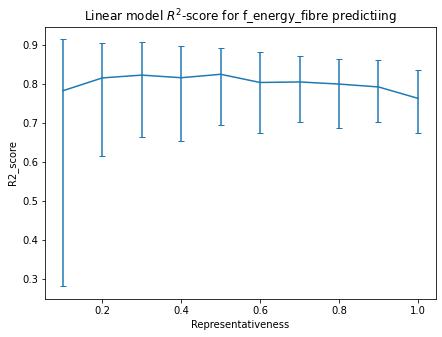

In [106]:
fog, ax = plt.subplots(1,1)
ax.errorbar(repres_vals, r2_estimators[target], 
             yerr = [r2_estimators[target] - r2_lower_CIs[target], - r2_estimators[target] + r2_upper_CIs[target]], 
             capsize= 3)
ax.set_xlabel('Representativeness')
ax.set_ylabel('R2_score')
ax.set_title(f'Linear model $R^2$-score for {target} predictiing')

# Linear model for f_energy_alcohol

In [107]:
target = 'f_energy_alcohol'
df_enerfy_fat = get_label_summary(target, selected_cols_best[target])
df_enerfy_fat

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.0093,0.000074,124.601,0.000,0.009,0.009000
"Q(""Level >=4 qualifications"")",0.0014,0.000000,12.850,0.000,0.001,0.002000
"Q(""IOD AVG"")",0.0005,0.000000,4.531,0.000,0.000,0.001000
"Q(""Muslim"")",-0.0010,0.000000,-6.117,0.000,-0.001,-0.001000
"Q(""Other religions"")",-0.0002,0.000078,-3.170,0.002,-0.000,-0.000094


In [108]:
selected_cols_very_best[target] = [actual_name(col) for col in list(df_enerfy_fat.index) if col != 'Intercept']
n = len(df_ward_atlas)
r2_estimators[target] = []
r2_lower_CIs[target] = []
r2_upper_CIs[target] = []
for repres in repres_vals:
    num_samples = int(n * repres)
    r2_scores = get_r2_samples(target, selected_cols_very_best[target], df_ward_atlas[:num_samples])
    estimator, lower_CI, upper_CI = estimate_from_samples(r2_scores)
    print(f'repres = {repres},', estimator, lower_CI, upper_CI)
    r2_estimators[target].append(estimator)
    r2_lower_CIs[target].append(lower_CI)
    r2_upper_CIs[target].append(upper_CI)
r2_estimators[target] = np.array(r2_estimators[target])
r2_lower_CIs[target] = np.array(r2_lower_CIs[target])
r2_upper_CIs[target] = np.array(r2_upper_CIs[target])

repres = 0.1, 0.3975965928116541 -1.7051789496898726 0.7217232138939598
repres = 0.2, 0.633219557292738 -0.07468248396200616 0.8378500229365817
repres = 0.30000000000000004, 0.6253948554528644 0.19278630706736366 0.8025457628170489
repres = 0.4, 0.5607886722980829 0.25565663814596173 0.7414771721522728
repres = 0.5, 0.5864978405662437 0.30831021254826707 0.7460771073269096
repres = 0.6, 0.5308441679738851 0.30372704994791955 0.693629369911614
repres = 0.7000000000000001, 0.4924219452265946 0.31781190292978834 0.6447382578760765
repres = 0.8, 0.4867868241544655 0.3042600551629341 0.6180009055840743
repres = 0.9, 0.4786463423125632 0.31721248104800237 0.5963613276989517
repres = 1.0, 0.4375812535102907 0.27045118522695233 0.554146630018457


Text(0.5, 1.0, 'Linear model $R^2$-score for f_energy_alcohol predictiing')

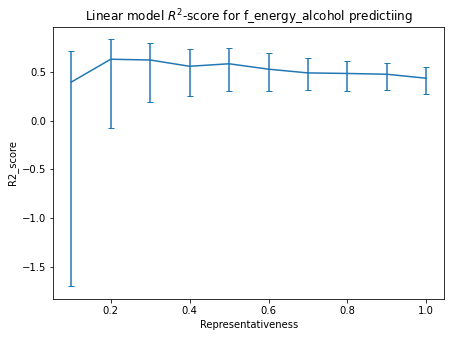

In [109]:
fog, ax = plt.subplots(1,1)
ax.errorbar(repres_vals, r2_estimators[target], 
             yerr = [r2_estimators[target] - r2_lower_CIs[target], - r2_estimators[target] + r2_upper_CIs[target]], 
             capsize= 3)
ax.set_xlabel('Representativeness')
ax.set_ylabel('R2_score')
ax.set_title(f'Linear model $R^2$-score for {target} predictiing')

In [113]:
r2_estimators

{'f_energy_fat': array([0.60288675, 0.52551094, 0.50694007, 0.53161466, 0.51805443,
        0.5218888 , 0.53034966, 0.52664874, 0.4829546 , 0.44021859]),
 'f_energy_saturate': array([0.4313485 , 0.49000143, 0.5340617 , 0.58819967, 0.57888112,
        0.53107747, 0.51709428, 0.49074987, 0.46405639, 0.41864812]),
 'f_energy_sugar': array([0.20128759, 0.24828905, 0.34575294, 0.32898149, 0.34031322,
        0.32228866, 0.32048562, 0.36421614, 0.3953901 , 0.41414083]),
 'f_energy_carb': array([0.72068565, 0.76287395, 0.77344576, 0.7721508 , 0.76187869,
        0.75150413, 0.74288102, 0.72955032, 0.72065334, 0.6978524 ]),
 'f_energy_fibre': array([0.78305207, 0.816073  , 0.82328257, 0.81652603, 0.82536541,
        0.80431835, 0.80569572, 0.8002211 , 0.79285571, 0.7635467 ]),
 'f_energy_alcohol': array([0.39759659, 0.63321956, 0.62539486, 0.56078867, 0.58649784,
        0.53084417, 0.49242195, 0.48678682, 0.47864634, 0.43758125])}

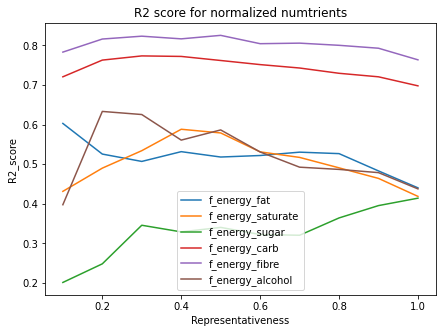

In [116]:
fog, ax = plt.subplots(1,1)
for nutrient in r2_estimators.keys():
    ax.plot(repres_vals, r2_estimators[nutrient], label=nutrient)
ax.set_xlabel('Representativeness')
ax.set_ylabel('R2_score')
ax.set_title(f'R2 score for normalized nutrients')
ax.legend()
plt.show()

Comparison between energy_nutrient vs f_energy_nutrient r2-scores: <br>
fat: 0.376 vs <b>0.455</b> <br>
saturate: 0.374 vs <b>0.457</b><br>
sugar: <b>0.590</b> vs 0.429<br>
protein: 0.613 vs <b>0.718</b><br>
carb: <b>0.776</b> vs 0.714<br>
fibre: 0.623 vs <b>0.775</b><br>
alcohol: 0.418 vs <b>0.456</b><br>

# Neural Network for predicting all at once

In [24]:
import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.losses import KLDivergence

In [25]:
target_cols = ['f_energy_fat', 'f_energy_protein', 'f_energy_carb', 'f_energy_fibre', 'f_energy_alcohol']

In [26]:
df_ward_atlas[target_cols].sum(axis=1)

E05000026    1.0
E05000027    1.0
E05000028    1.0
E05000029    1.0
E05000030    1.0
            ... 
E05000645    1.0
E05000646    1.0
E05000647    1.0
E05000648    1.0
E05000649    1.0
Length: 483, dtype: float64

In [37]:
any(np.abs(df_ward_atlas[target_cols].sum(axis=1) - 1 > 0.01))

False

In [63]:
model = Sequential()
model.add(Input(shape=(30,)))
model.add(Dense(5, activation='softmax'))
model.compile(optimizer='sgd', 
              loss=KLDivergence(), 
              metrics=['mean_absolute_error'])

In [60]:
x_data = df_ward_atlas[all_features]
y_data = df_ward_atlas[target_cols]
#x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.2)

In [64]:
history = model.fit(x_data, y_data, validation_split=0.2, epochs=300)

Train on 386 samples, validate on 97 samples
Epoch 1/300
386/386 [==============================] - 0s 223us/sample - loss: 0.6217 - mean_absolute_error: 0.1945 - val_loss: 0.4717 - val_mean_absolute_error: 0.1681
Epoch 2/300
386/386 [==============================] - 0s 38us/sample - loss: 0.5361 - mean_absolute_error: 0.1789 - val_loss: 0.4070 - val_mean_absolute_error: 0.1544
Epoch 3/300
386/386 [==============================] - 0s 47us/sample - loss: 0.4643 - mean_absolute_error: 0.1648 - val_loss: 0.3514 - val_mean_absolute_error: 0.1417
Epoch 4/300
386/386 [==============================] - 0s 54us/sample - loss: 0.4010 - mean_absolute_error: 0.1510 - val_loss: 0.3049 - val_mean_absolute_error: 0.1301
Epoch 5/300
386/386 [==============================] - 0s 54us/sample - loss: 0.3477 - mean_absolute_error: 0.1383 - val_loss: 0.2665 - val_mean_absolute_error: 0.1194
Epoch 6/300
386/386 [==============================] - 0s 53us/sample - loss: 0.3057 - mean_absolute_error: 0.1273

386/386 [==============================] - 0s 43us/sample - loss: 0.0089 - mean_absolute_error: 0.0134 - val_loss: 0.0074 - val_mean_absolute_error: 0.0132
Epoch 97/300
386/386 [==============================] - 0s 44us/sample - loss: 0.0087 - mean_absolute_error: 0.0133 - val_loss: 0.0073 - val_mean_absolute_error: 0.0131
Epoch 98/300
386/386 [==============================] - 0s 44us/sample - loss: 0.0086 - mean_absolute_error: 0.0132 - val_loss: 0.0072 - val_mean_absolute_error: 0.0130
Epoch 99/300
386/386 [==============================] - 0s 41us/sample - loss: 0.0084 - mean_absolute_error: 0.0131 - val_loss: 0.0071 - val_mean_absolute_error: 0.0130
Epoch 100/300
386/386 [==============================] - 0s 41us/sample - loss: 0.0083 - mean_absolute_error: 0.0130 - val_loss: 0.0070 - val_mean_absolute_error: 0.0129
Epoch 101/300
386/386 [==============================] - 0s 44us/sample - loss: 0.0082 - mean_absolute_error: 0.0130 - val_loss: 0.0069 - val_mean_absolute_error: 0.01

Epoch 144/300
386/386 [==============================] - 0s 38us/sample - loss: 0.0047 - mean_absolute_error: 0.0106 - val_loss: 0.0042 - val_mean_absolute_error: 0.0107
Epoch 145/300
386/386 [==============================] - 0s 36us/sample - loss: 0.0047 - mean_absolute_error: 0.0106 - val_loss: 0.0042 - val_mean_absolute_error: 0.0106
Epoch 146/300
386/386 [==============================] - 0s 36us/sample - loss: 0.0046 - mean_absolute_error: 0.0106 - val_loss: 0.0041 - val_mean_absolute_error: 0.0106
Epoch 147/300
386/386 [==============================] - 0s 39us/sample - loss: 0.0046 - mean_absolute_error: 0.0105 - val_loss: 0.0041 - val_mean_absolute_error: 0.0106
Epoch 148/300
386/386 [==============================] - 0s 35us/sample - loss: 0.0045 - mean_absolute_error: 0.0105 - val_loss: 0.0041 - val_mean_absolute_error: 0.0105
Epoch 149/300
386/386 [==============================] - 0s 36us/sample - loss: 0.0045 - mean_absolute_error: 0.0104 - val_loss: 0.0040 - val_mean_abs

386/386 [==============================] - 0s 41us/sample - loss: 0.0025 - mean_absolute_error: 0.0085 - val_loss: 0.0025 - val_mean_absolute_error: 0.0086
Epoch 241/300
386/386 [==============================] - 0s 41us/sample - loss: 0.0025 - mean_absolute_error: 0.0085 - val_loss: 0.0025 - val_mean_absolute_error: 0.0086
Epoch 242/300
386/386 [==============================] - 0s 36us/sample - loss: 0.0025 - mean_absolute_error: 0.0085 - val_loss: 0.0024 - val_mean_absolute_error: 0.0085
Epoch 243/300
386/386 [==============================] - 0s 41us/sample - loss: 0.0025 - mean_absolute_error: 0.0085 - val_loss: 0.0024 - val_mean_absolute_error: 0.0085
Epoch 244/300
386/386 [==============================] - 0s 36us/sample - loss: 0.0025 - mean_absolute_error: 0.0085 - val_loss: 0.0024 - val_mean_absolute_error: 0.0086
Epoch 245/300
386/386 [==============================] - 0s 41us/sample - loss: 0.0025 - mean_absolute_error: 0.0085 - val_loss: 0.0024 - val_mean_absolute_error: 0

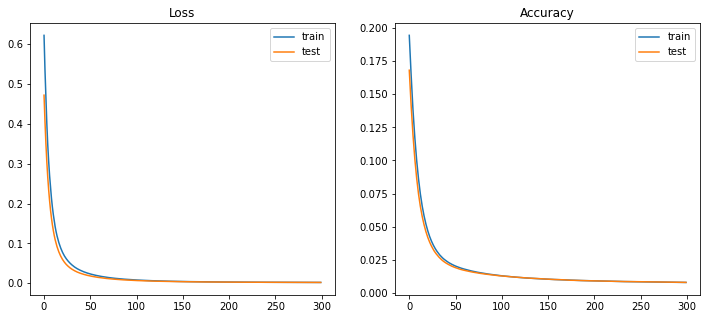

In [75]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))
ax[0].plot(history.history['loss'], label='train')
ax[0].plot(history.history['val_loss'], label='test')
ax[0].set_title('Loss')
ax[0].legend()
ax[1].plot(history.history['mean_absolute_error'], label='train')
ax[1].plot(history.history['val_mean_absolute_error'], label='test')
ax[1].set_title('Accuracy')
ax[1].legend()
plt.show()